In [11]:
# Chaitra Pirisingula
# Shruti Pradeep
# 04/10/2023 

In [12]:
from ColorBlindnessAnalysis import simulate_colorblindness, get_colors, get_color_similarity_scores, display_charts
import numpy as np
import cv2

In [13]:
# This matrix simulates protanopia, one of the most common forms of color blindness (Red-blind)
protanopia_simulation_matrix = np.array([[0.567, 0.433, 0],
                                [0.558, 0.442, 0],
                                [0, 0.242, 0.758]])

# This matrix simulates deuteranopia, another common form of color blindness (Green-blind)
deuteranopia_simulation_matrix = np.array([[0.625, 0.375, 0],
                                [0.7, 0.3, 0],
                                [0, 0.3, 0.7]])

# This matrix simulates tritanopia, a rare form of color blindness (Blue-yellow)
tritanopia_simulation_matrix = np.array([[0.95, 0.05, 0],
                                [0, 0.433, 0.567],
                                [0, 0.475, 0.525]])

protanomaly_simulation_matrix = np.array([[0.817,0.183,0.000],
                                [0.333,0.667,0.000],
                                [0.000,0.125,0.875]])

deuteranomaly_simulation_matrix = np.array([[0.800,0.200,0.000],
                                [0.258,0.742,0.000],
                                [0.000,0.142,0.858]])

tritanomaly_simulation_matrix = np.array([[0.967,0.033,0.00],
                                [0.00,0.733,0.267],
                                [0.00,0.183,0.817]])

achromatopsia_simulation_matrix = np.array([[0.299,0.587,0.114],
                                [0.299,0.587,0.114],
                                [0.299,0.587,0.114]])

achromatomaly_simulation_matrix = np.array([[0.618,0.320,0.062],
                                [0.163,0.775,0.062],
                                [0.163,0.320,0.516]])

cb_masks = [protanopia_simulation_matrix, deuteranopia_simulation_matrix, tritanopia_simulation_matrix]
cb_names = ["Protanopia", "Deuteranopia", "Tritanopia"]

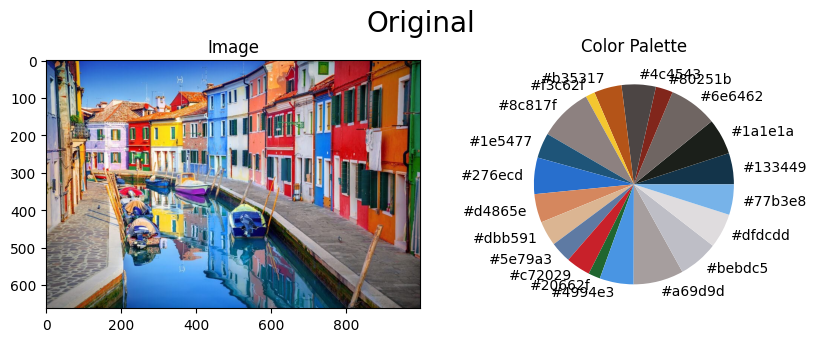

In [14]:
# Load original image
image = cv2.imread('images/houses.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Get original colors and corresponding colorblindness colors with delta e scores
original_colors = get_colors(image, 20, "Original")
cb_scores = get_color_similarity_scores(original_colors, cb_names, cb_masks)

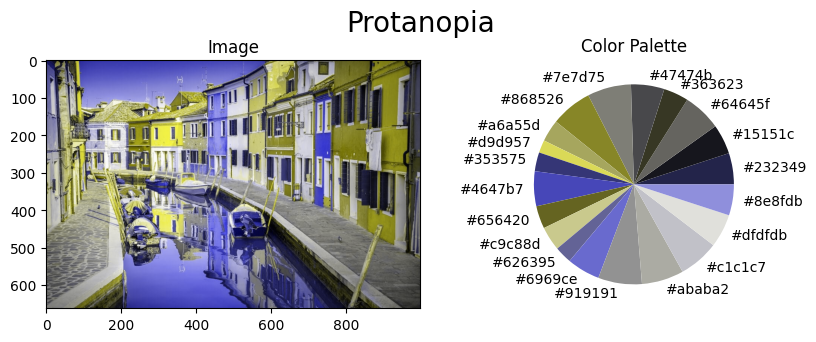

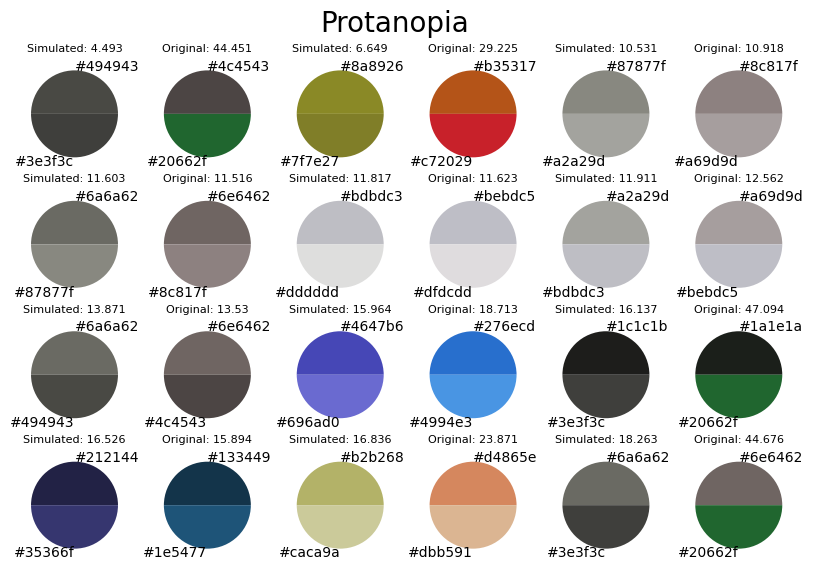

In [15]:
# Simulate Protanopia and display results 
protanopia_image = simulate_colorblindness(protanopia_simulation_matrix, image)
protanopia_colors = get_colors(protanopia_image, 20, cb_names[0])
display_charts(cb_names[0], cb_scores[cb_names[0]])

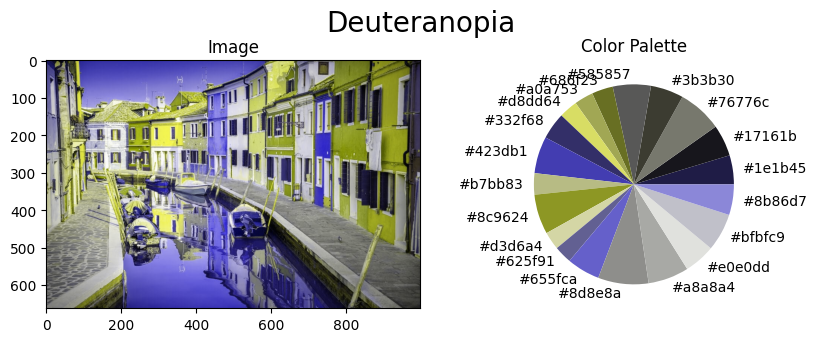

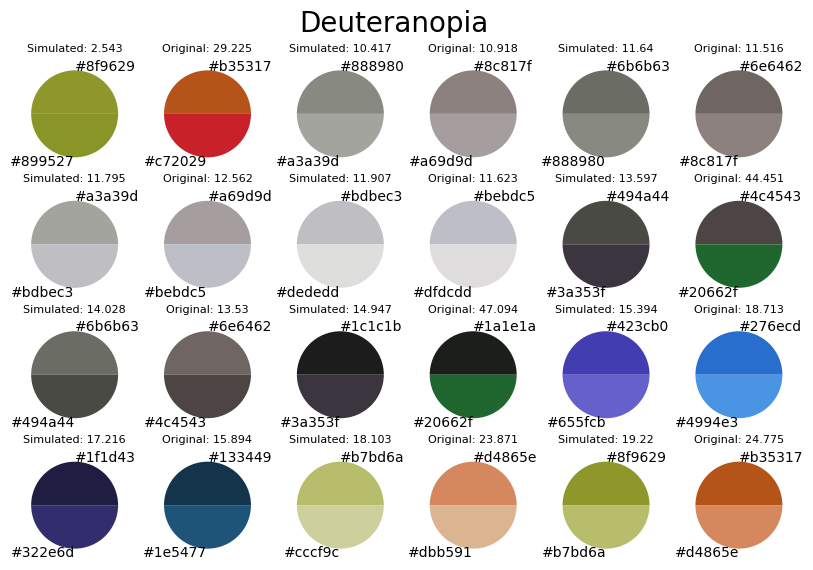

In [16]:
# Simulate Deuteranopia and display results 
deuteranopia_image = simulate_colorblindness(deuteranopia_simulation_matrix, image)
deuteranopia_colors = get_colors(deuteranopia_image, 20, cb_names[1])
display_charts(cb_names[1], cb_scores[cb_names[1]])

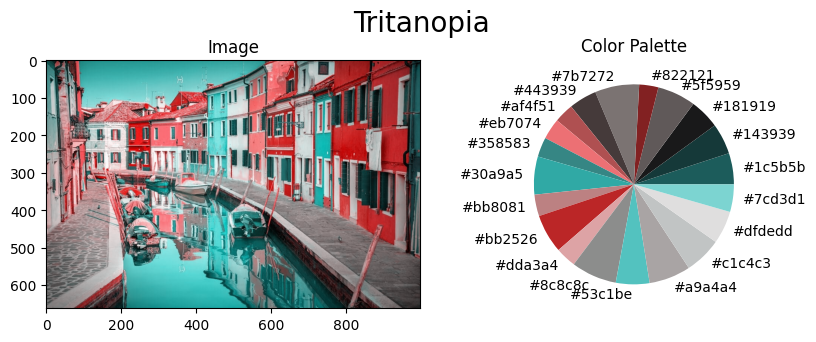

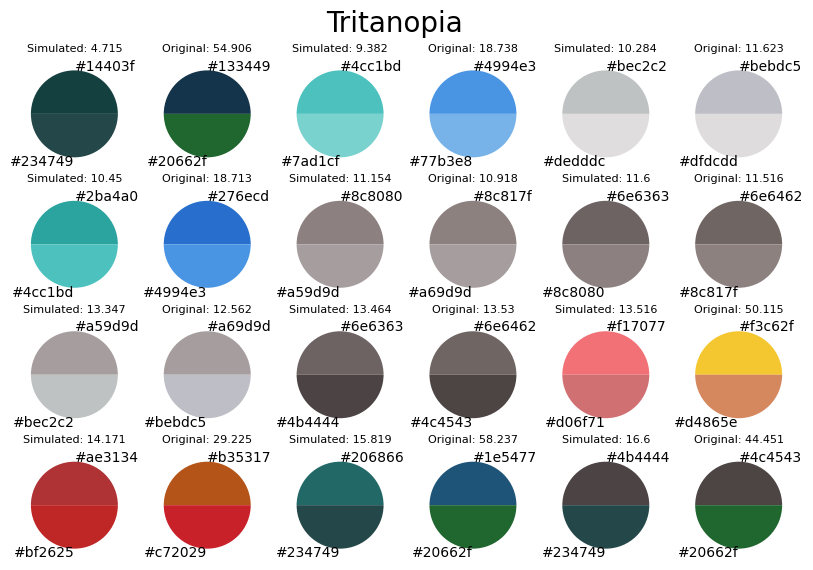

In [17]:
# Simulate Tritanopia and display results 
tritanopia_image = simulate_colorblindness(tritanopia_simulation_matrix, image)
tritanopia_colors = get_colors(tritanopia_image, 20, cb_names[2])
display_charts(cb_names[2], cb_scores[cb_names[2]])

In [ ]:
# Color ranges (in HSV format)
lower_blue = np.array([100, 50, 50]) 
upper_blue = np.array([130, 255, 255]) 

lower_green = np.array([60, 25, 0])
upper_green = np.array([180, 255, 255])

lower_red1 = np.array([0, 25, 0])
upper_red1 = np.array([30, 255, 255])
lower_red2 = np.array([150, 25, 0])
upper_red2 = np.array([180, 255, 255])

lower_yellow = np.array([30, 25, 0])
upper_yellow = np.array([60, 255, 255]) 

lower_orange1 = np.array([0, 25, 0])
upper_orange1 = np.array([30, 255, 255])
lower_orange2 = np.array([160, 25, 0])
upper_orange2 = np.array([180, 255, 255])

# Replaces color in image
def replace_color(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # # Convert the image to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Create a mask with the pixels within the color range
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Replace the color with another color (in BGR format)
    new_color = np.array([0, 0, 255]) # red color in BGR format
    img[mask > 0] = new_color

    # Convert the image to RGB color space
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return rgb


image = cv2.imread('images/powerpuff_girls.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_colors = get_colors(image, 20, "Original")

recolored_image = replace_color("images/powerpuff_girls.png")
recolored_colors = get_colors(recolored_image, 20, "Recolored")

protanopia_image = simulate_colorblindness(protanopia_simulation_matrix, image)
protanopia_colors = get_colors(protanopia_image, 20, cb_names[0])

protanopia_image = simulate_colorblindness(protanopia_simulation_matrix, recolored_image)
protanopia_colors = get_colors(protanopia_image, 20, cb_names[0])
